# Detecting Power Outages with Tweets
### Sang Cheon, Ethan Henley, and Jason Morman
### Notebook 02: Exploratory Data Analysis

## Notebook 02 Contents:

- [Loading](#Loading)
- [EDA](#EDA)
    - [EIA Data](#EIA-Data)
    - [Tweet Data](#Tweet-Data)
    - [Customers Affected and Relevant Tweets](#Customers-Affected-and-Relevant-Tweets)
    - [Corpus of Outage-Related Tweets](#Corpus-of-Outage-Related-Tweets)

## Loading

Imports.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import datetime
from matplotlib.dates import date2num

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Load EIA data.

In [3]:
df = pd.read_csv('../data/washington_outages.csv')

Load tweets.

In [4]:
df_tweet = pd.read_csv('../data/wa_tweets.csv')

## EDA

### EIA Data

In [5]:
df

,Area Affected,index,Year,Month,Event Date and Time,Restoration Date and Time,Duration,Utility/Power Pool,NERC Region,Type of Disturbance,Loss (megawatts),Number of Customers Affected
0,King,2,2012,1.0,2012-01-19 07:00:00,2012-01-20 15:00:00,"32 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather - Winter Storm,1600,426000
1,Pierce,2,2012,1.0,2012-01-19 07:00:00,2012-01-20 15:00:00,"32 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather - Winter Storm,1600,426000
2,Thurston,2,2012,1.0,2012-01-19 07:00:00,2012-01-20 15:00:00,"32 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather - Winter Storm,1600,426000
3,WA,22,2013,5.0,2013-05-09 13:21:00,2013-05-09 16:21:00,"3 Hours, 0 Minutes",WECC,WECC,Electrical System Separation (Islanding),Unknown,Unknown
4,King,72,2013,11.0,2013-11-02 00:00:00,2013-11-04 06:00:00,"54 Hours, 0 Minutes",Puget Sound Energy,WECC,Severe Weather - Heavy Winds,Unknown,105000
...,...,...,...,...,...,...,...,...,...,...,...,...
68,Skagit,125,2018,12.0,2018-12-20 09:30:00,2018-12-20 17:00:00,"7 Hours, 30 Minutes",Puget Sound Energy,WECC,"Loss of electric service to more than 50,000 c...",Unknown,165000
69,Snohomish,125,2018,12.0,2018-12-20 09:30:00,2018-12-20 17:00:00,"7 Hours, 30 Minutes",Puget Sound Energy,WECC,"Loss of electric service to more than 50,000 c...",Unknown,165000
70,King,125,2018,12.0,2018-12-20 09:30:00,2018-12-20 17:00:00,"7 Hours, 30 Minutes",Puget Sound Energy,WECC,"Loss of electric service to more than 50,000 c...",Unknown,165000
71,Kitsap,125,2018,12.0,2018-12-20 09:30:00,2018-12-20 17:00:00,"7 Hours, 30 Minutes",Puget Sound Energy,WECC,"Loss of electric service to more than 50,000 c...",Unknown,165000


In [6]:
df.dtypes

Area Affected                    object
index                             int64
Year                              int64
Month                           float64
Event Date and Time              object
Restoration Date and Time        object
Duration                         object
Utility/Power Pool               object
NERC Region                      object
Type of Disturbance              object
Loss (megawatts)                 object
Number of Customers Affected     object
dtype: object

In [7]:
df[df['Number of Customers Affected']!='Unknown']['index'].unique()

array([  2,  72, 124, 126, 134,  23,  43,  61,  69,  70,  71,  79,  80,
        81,  88,  10,  54,  74,  75,  84,  85,  64, 123, 125], dtype=int64)

### Tweet Data

Inspect our positive class.

In [8]:
df_tweet_outage = df_tweet[df_tweet['outage'] == 1]

In [9]:
df_tweet_outage['timestamp'] = pd.to_datetime(df_tweet_outage['timestamp'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df_tweet.dtypes

event_row_or_county    object
timestamp              object
text                   object
outage                  int64
dtype: object

### Customers Affected and Relevant Tweets

Compare customers affected with outage tweet count.

In [11]:
df[df['Number of Customers Affected']=='Unknown']

,Area Affected,index,Year,Month,Event Date and Time,Restoration Date and Time,Duration,Utility/Power Pool,NERC Region,Type of Disturbance,Loss (megawatts),Number of Customers Affected
3,WA,22,2013,5.0,2013-05-09 13:21:00,2013-05-09 16:21:00,"3 Hours, 0 Minutes",WECC,WECC,Electrical System Separation (Islanding),Unknown,Unknown
16,WA,56,2015,7.0,2015-07-21 12:47:00,2015-07-21 13:12:00,"0 Hours, 25 Minutes",Peak Reliability,WECC,Load shedding of 100 Megawatts or more impleme...,200,Unknown
39,Clark,16,2016,5.0,2016-05-08 09:12:00,2016-05-08 09:12:00,ongoing,Peak Reliability,WECC,Electrical System Separation (Islanding) where...,Unknown,Unknown
40,King,52,2016,8.0,2016-08-24 19:18:00,2016-08-24 19:47:00,"0 Hours, 29 Minutes",Peak Reliability,WECC,Electrical System Separation (Islanding) where...,9232,Unknown
42,Clark,59,2016,9.0,2016-09-06 18:12:00,2016-09-06 21:24:00,"3 Hours, 12 Minutes",Peak Reliability,WECC,Electrical System Separation (Islanding) where...,300,Unknown
44,Clark,62,2016,9.0,2016-09-10 09:42:00,2016-09-10 09:57:00,"0 Hours, 15 Minutes",Peak Reliability,WECC,Load shedding of 100 Megawatts or more impleme...,135,Unknown
47,WA,76,2017,10.0,2017-10-20 03:44:00,2017-10-20 03:45:00,"0 Hours, 1 Minutes",Peak Reliability,WECC,Uncontrolled loss of 300 Megawatts or more of ...,900,Unknown
58,Clark,78,2018,7.0,2018-07-27 09:34:00,2018-07-27 09:51:00,"0 Hours, 17 Minutes",Peak Reliability,WECC,Electrical System Separation (Islanding) where...,Unknown,Unknown


In [12]:
df['Number of Customers Affected'].replace('Unknown',0, inplace = True)

In [13]:
df['Number of Customers Affected'] = df['Number of Customers Affected'].astype('int64')

A plot of customers affected by each outage over time. 

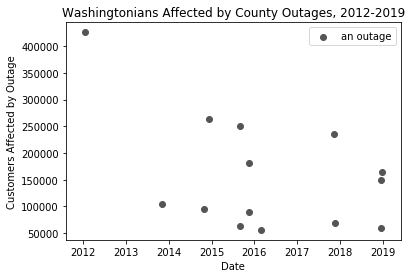

In [14]:
outages_for_plotting = \
    df[df['Area Affected']!='WA'].drop(
    columns=['Area Affected']).drop_duplicates()
outages_for_plotting['Event Date and Time'] = \
    pd.to_datetime(outages_for_plotting['Event Date and Time'])
outages_for_plotting['no_cust_aff'] = \
    outages_for_plotting['Number of Customers Affected'].map(
        lambda n: 0 if n == 'Unknown' else int(n))
ofp = outages_for_plotting[['Event Date and Time','no_cust_aff']]
ofp = ofp[ofp['no_cust_aff']!=0]

plt.scatter(ofp['Event Date and Time'], ofp['no_cust_aff'], 
            c='#555555')

plt.xlabel('Date')
plt.ylabel('Customers Affected by Outage')
plt.title('Washingtonians Affected by County Outages, 2012-2019')
plt.legend(['an outage']);
plt.savefig('../figures/wa_outage_pops.png')

A histogram of tweets about outages in the same areas over time.

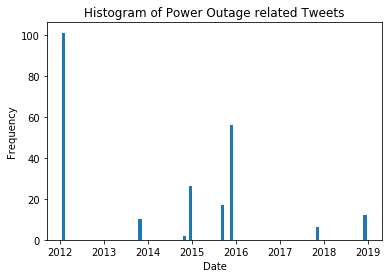

In [15]:
plt.hist(df_tweet_outage['timestamp'], bins = (12*8));
plt.gca().set(title='Histogram of Power Outage related Tweets', ylabel='Frequency', xlabel = 'Date');

Compare graphically customers affected by outages vs confirmed outage tweets for major county-level outages in Washington state.

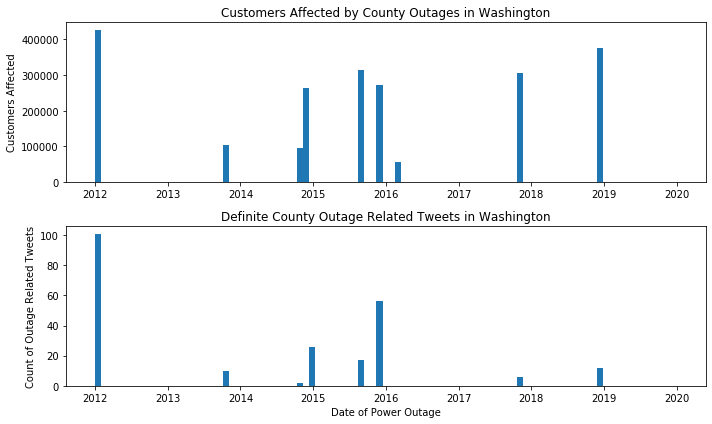

In [16]:
bins = pd.date_range(pd.datetime(2012,1,1),
                     pd.datetime(2020,1,1),
                     periods=12*8).date
bins = date2num(bins)

ofp_long_ind = []
for i in ofp.index:
    ofp_long_ind += [i]*ofp.loc[i,'no_cust_aff']
ofp_long = ofp.loc[ofp_long_ind, 'Event Date and Time']

plt.figure(figsize = (10,6))
ax1 = plt.subplot(211)
ax1.set_title('Customers Affected by County Outages in Washington')
ax1.set_ylabel('Customers Affected')
ax1 = plt.hist(ofp_long, bins=bins)
ax2 = plt.subplot(212)
ax2.set_title('Definite County Outage Related Tweets in Washington')
ax2.set_ylabel('Count of Outage Related Tweets')
ax2.set_xlabel('Date of Power Outage');
ax2 = plt.hist(df_tweet_outage['timestamp'], bins=bins);
plt.tight_layout()
plt.savefig('../figures/PowerOutageSubPlots.png')

We can see that many outages were underrepresented, and additionally, few people clearly tweet about outages. However, we were still able to gather tweets for major county-level outages.

### Corpus of Outage-Related Tweets

In [17]:
stops = stopwords.words('english')

The following function is adapted from the work of Noah Christiansen, Jen Hill, and Vonn Napoleon Johnson, available [here](https://github.com/jenrhill/Power_Outage_Identification). We'll use it to clean the tweets down to relevant word lists.

In [18]:
# this function adapted from christiansen et al's
# tweets_to_tweetlist
# cleans, reformats, tokenizes, and removes stopwords from tweets

def tweets_cleaner(raw):
    
    clean = str(raw).replace('-',' ').replace('#',' ')
    clean = re.sub(r"([@][\w_-]+)", "", clean) # remove handles
    clean = re.sub(r"http.*?\b","",clean)
    clean = re.sub(r"pictwitter.*?\b","",clean)
    clean = re.sub(r"www.*?\b","",clean)
    clean = re.sub(r"[^a-zA-Z ]", "", clean)
    clean = clean.lower().split()
    clean = [w for w in clean if w not in stops]
    return clean

In [19]:
# Iterate through all_tweets, clean tweets and add to tweet_list
all_tweets = df_tweet_outage['text']
tweet_list = []

for tweet in all_tweets:
    tweet_list.append(tweets_cleaner(tweet))
len(tweet_list)

230

In [20]:
# accounting for multiple names used in sang's code
tokenized_tweet_list = tweet_list
final_tweet_list = tokenized_tweet_list

We flatten the tweet word lists to get a corpus of tweet words.

In [21]:
flattened_list = [y for x in final_tweet_list for y in x]

In [22]:
flattened_list

['power',
 'issaquah',
 'highlands',
 'understand',
 'issaquah',
 'situation',
 'tiger',
 'mountain',
 'rd',
 'se',
 'block',
 'way',
 'blocking',
 'trees',
 'power',
 'lines',
 'se',
 'may',
 'valley',
 'road',
 'closed',
 'moment',
 'tree',
 'n',
 'power',
 'lines',
 'everywhere',
 'miles',
 'w',
 'iss',
 'hobart',
 'rd',
 'lost',
 'power',
 'power',
 'better',
 'back',
 'update',
 'power',
 'outages',
 'affecting',
 'rentons',
 'benson',
 'neighborhood',
 'bitlyapsjyr',
 'via',
 'outsidein',
 'still',
 'power',
 'reminds',
 'still',
 'love',
 'board',
 'games',
 'breaking',
 'monopoly',
 'battleship',
 'power',
 'issaquah',
 'hrs',
 'help',
 'power',
 'water',
 'fuckinicestorms',
 'power',
 'suckage',
 'fully',
 'started',
 'thats',
 'good',
 'power',
 'days',
 'waice',
 'wapower',
 'power',
 'outage',
 'issaquah',
 'highlands',
 'power',
 'went',
 'lets',
 'use',
 'nat',
 'gas',
 'supplies',
 'cog',
 'rrc',
 'beatdown',
 'seattle',
 'power',
 'burning',
 'nat',
 'gas',
 'days',
 's

We count and plot the most frequent words in the corpus.

In [23]:
d = {x:flattened_list.count(x) for x in flattened_list}

In [24]:
#Creating dataframe by converting dict to list of items

list_common_words = pd.DataFrame(list(d.items()))

In [25]:
list_common_words.rename(columns={0:'Word',
                          1:'Count'}, 
                 inplace=True)

In [26]:
short_common_words = list_common_words.sort_values(by='Count', ascending = False).head(10)
short_common_words

,Word,Count
0,power,240
58,outage,20
38,still,20
36,via,15
88,night,12
28,back,12
59,went,12
37,outsidein,11
100,storm,11
71,im,11


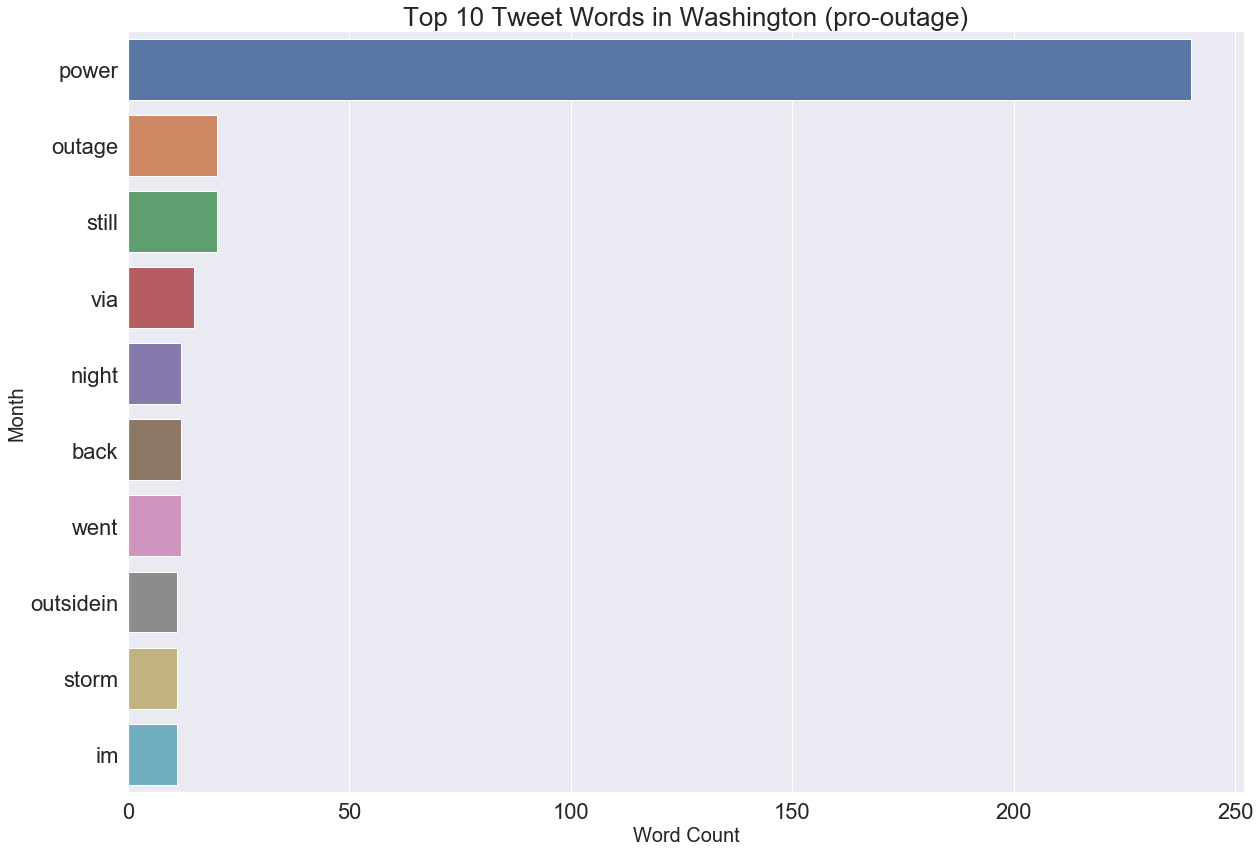

In [27]:
plt.figure(figsize = (20,14))

sns.set_style("whitegrid")
sns.set(font_scale = 2)
ax3 = sns.barplot(data=short_common_words.head(10),x='Count',y='Word',orient='h')
ax3.set_xlabel('Word Count', fontsize=20)
ax3.set_ylabel('Month', fontsize=20)
ax3.set_title('Top 10 Tweet Words in Washington (pro-outage)',fontsize = 26)

plt.savefig('../figures/TopTweetWords.png')

It is clear that 'power' is the most common word in the outage corpus. We also get numerous other words that seem at least somewhat related—this is encouraging, as it suggests that we will be able to use word choice to determine outage-relatedness.

[**Go to next notebook.**](./03_model_conclusion.ipynb)